In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
# from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as spio

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

from evaluation import accuracy
from evaluation import areaundercurve
from evaluation import average_precision_score_computation

from encoders import Encoder
from aggregators import MeanAggregator

Using matplotlib backend: agg


In [2]:
class SAGEConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, normalize=False, bias=True):
        super(SAGEConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.linear = torch.nn.Linear(self.in_channels, out_channels, bias=False)
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
            torch.nn.init.zeros_(self.bias)
        else:
            self.register_parameter('bias', None)


    def forward(self, x, adj):
        out = torch.matmul(adj, x)
        out = out / adj.sum(dim=-1, keepdim=True).clamp(min=1)
        out = self.linear(out)

        if self.bias is not None:
            out = out + self.bias

        if self.normalize:
            out = F.normalize(out, p=2, dim=-1)

        return out

class Net(torch.nn.Module):
    def __init__(self, in_dim, out_dim, data):
        super(Net, self).__init__()
        self.conv1 = SAGEConv(in_dim, 16)
        self.conv2 = SAGEConv(16, out_dim)
        
        injection = torch.ones_like(data.adj) * 0.01
        injection = torch.abs(injection)
        self.injection = torch.nn.Parameter(
            injection, 
            requires_grad=True
        )

    def forward(self, data):
        x, adj = data.x, data.adj
        
        # link injection
#         injection = F.relu(self.injection)
        injection = F.leaky_relu(self.injection)
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
        
        x = self.conv1(x, adj)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, adj)

        return F.log_softmax(x, dim=1)

In [3]:
from tqdm import tqdm

NUMEPOCHS = 20000
early_stop_win_size = 100
tolerance = 1.00

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# load data
name = 'Cora'
dataset = Planetoid('../datasets/'+ name, name=name)

in_dim = dataset.num_node_features
out_dim = dataset.num_classes

data = dataset.data

# random sampling edges
frac = 0.1
num_edges = data.edge_index.size(1)
perm = torch.randperm(num_edges)
idx = perm[:int(frac * num_edges)]
new_edge_index = data.edge_index[:, idx]

# using sparse graph
# data.adj = to_dense_adj(add_self_loops(new_edge_index)[0])[0]
data.adj = torch.zeros(data.x.size(0), data.x.size(0))
data = dataset.data.to(device)

# compile model
model = Net(
    in_dim,
    out_dim, 
    data
).to(device)

optimizer = torch.optim.Adamax(model.parameters(), weight_decay=1e-8)

In [4]:
# get the initial injection
injection_init = model.injection.detach().cpu().numpy()

In [5]:
# record accuracy
train_acc = np.zeros(NUMEPOCHS)
val_acc = np.zeros(NUMEPOCHS)
test_acc = np.zeros(NUMEPOCHS)

# training start
model.train()

for epoch in range(NUMEPOCHS):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    # record the accuracy
    train_acc[epoch] = accuracy(model, data, 'train')
    val_acc[epoch] = accuracy(model, data, 'val')
    test_acc[epoch] = accuracy(model, data, 'test')
    
    # early stopping
    if epoch > 2 * early_stop_win_size:
        prev_start = epoch - 2 * early_stop_win_size
        prev_end = epoch - early_stop_win_size
        current_start = epoch - early_stop_win_size
        current_end = epoch
        
        val_acc_current = np.mean(val_acc[current_start: current_end])
        val_acc_previous = np.mean(val_acc[prev_start: prev_end])
        
        if val_acc_current < val_acc_previous - tolerance:
            train_acc = train_acc[:epoch]
            val_acc = val_acc[:epoch]
            test_acc = test_acc[:epoch]
            print('Moving Average Early stopping at %d-th epoch' % epoch)
            print(
                'Previous validation average accuracy for %d-th to %d-th epoch: %f' % \
                (prev_start, prev_end, val_acc_previous)
            )
            print(
                'Current validation average accuracy for %d-th to %d-th epoch: %f' % \
                (current_start, current_end, val_acc_current)
            )
            break
    if epoch % 100 == 0:
        print(
            epoch, 
            'training acc =', train_acc[epoch], 
            'validation acc =', val_acc[epoch], 
            ', loss =', loss.item()
        )

0 training acc = 0.14285714285714285 validation acc = 0.156 , loss = 1.9459189176559448
100 training acc = 0.5714285714285714 validation acc = 0.058 , loss = 1.2654179334640503
200 training acc = 0.8571428571428571 validation acc = 0.058 , loss = 0.5910870432853699
300 training acc = 1.0 validation acc = 0.078 , loss = 0.08435976505279541
400 training acc = 1.0 validation acc = 0.078 , loss = 0.011989743448793888
500 training acc = 1.0 validation acc = 0.078 , loss = 0.004404391627758741
600 training acc = 1.0 validation acc = 0.08 , loss = 0.0023542132694274187
700 training acc = 1.0 validation acc = 0.082 , loss = 0.0014953272184357047
800 training acc = 1.0 validation acc = 0.08 , loss = 0.0010370629606768489
900 training acc = 1.0 validation acc = 0.082 , loss = 0.0007620164542458951
1000 training acc = 1.0 validation acc = 0.084 , loss = 0.0005812032031826675
1100 training acc = 1.0 validation acc = 0.084 , loss = 0.00045272623538039625
1200 training acc = 1.0 validation acc = 0.0

11800 training acc = 1.0 validation acc = 0.162 , loss = 0.0
11900 training acc = 1.0 validation acc = 0.162 , loss = 0.0
12000 training acc = 1.0 validation acc = 0.162 , loss = 0.0
12100 training acc = 1.0 validation acc = 0.162 , loss = 0.0
12200 training acc = 1.0 validation acc = 0.162 , loss = 0.0
12300 training acc = 1.0 validation acc = 0.162 , loss = 0.0
12400 training acc = 1.0 validation acc = 0.162 , loss = 0.0
12500 training acc = 1.0 validation acc = 0.162 , loss = 0.0
12600 training acc = 1.0 validation acc = 0.162 , loss = 0.0
12700 training acc = 1.0 validation acc = 0.162 , loss = 0.0
12800 training acc = 1.0 validation acc = 0.16 , loss = 0.0
12900 training acc = 1.0 validation acc = 0.16 , loss = 0.0
13000 training acc = 1.0 validation acc = 0.16 , loss = 0.0
13100 training acc = 1.0 validation acc = 0.16 , loss = 0.0
13200 training acc = 1.0 validation acc = 0.16 , loss = 0.0
13300 training acc = 1.0 validation acc = 0.16 , loss = 0.0
13400 training acc = 1.0 valid

In [17]:
# get the initial injection
injection_final = F.relu(model.injection.detach()).cpu().numpy()

In [18]:
print('Initial injection = \n', injection_init)
print('\nSum inital = %d\n' % np.sum(injection_init))
print('Final injection = \n', injection_final)
print('\nSum final = %d\n' % np.sum(injection_final))

Initial injection = 
 [[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]

Sum inital = 73333

Final injection = 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Sum final = 212



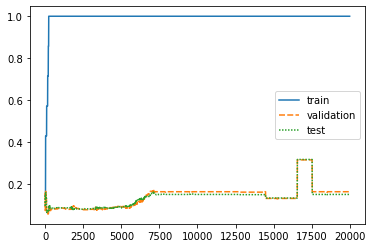

In [8]:
df_acc = pd.DataFrame({
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

sns.lineplot(data=df_acc)
plt.show()

In [9]:
spio.savemat('../variables/' + name + '/SAGEConv.mat',{
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

In [10]:
print('Train Accuracy: {:.4f}'.format(accuracy(model, data, 'train')))
print('Validation Accuracy: {:.4f}'.format(accuracy(model, data, 'val')))
print('Test Accuracy: {:.4f}'.format(accuracy(model, data, 'test')))

Train Accuracy: 1.0000
Validation Accuracy: 0.1620
Test Accuracy: 0.1490


In [11]:
print('Test AUC: {:.4f}'.format(areaundercurve(model, data, 'test')))

Test AUC: 0.5000


In [19]:
# 0% links
test_acc_all = np.array([0.3190, 0.3170, 0.3190, 0.3090, 0.1490])
test_auc_all = np.array([0.5000, 0.4997, 0.5004, 0.4975])

print(np.mean(test_acc_all))
print(np.mean(test_auc_all))

print(np.std(test_acc_all))
print(np.std(test_auc_all))

0.2826
0.4994
0.06690171896147362
0.0011247221879201888


[[ 909 2231]
 [ 232 2231]
 [1659 2231]
 ...
 [2144  968]
 [ 382 1238]
 [ 295  437]]
[1.0020143e+00 1.0020120e+00 1.0019733e+00 ... 3.0884179e-13 3.0884179e-13
 3.0880010e-13]
(10556, 2)
(10556,)


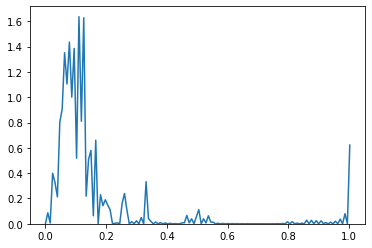

In [13]:
# get non-zero injected links
indexes = injection_final.nonzero()
index_arr = np.stack(indexes)
values = injection_final[indexes]

# sort injected links
sorted_idx = np.flip(np.argsort(values))

sorted_index = index_arr[:, sorted_idx]
sorted_values = values[sorted_idx]

# get the largest N out
num_edges = data.edge_index.size(1)
pred_index = sorted_index[:, :num_edges].T
pred_values = sorted_values[:num_edges]
print(pred_index)
print(pred_values)
print(pred_index.shape)
print(pred_values.shape)

sns.distplot(pred_values, hist=False)
plt.show()

In [14]:
true_index = data.edge_index.cpu().numpy().T

start = true_index[:, 0]

unq_val, unq_idx = np.unique(start, return_index=True)
start_dict = dict(zip(unq_val, unq_idx))

In [15]:
correct_list = []
for i in range(len(pred_index)):
    pred = pred_index[i]
    if pred[0] in start_dict:
        begin = start_dict[pred[0]]
        if pred[0] + 1 in start_dict:
            end = start_dict[pred[0] + 1]
        else:
            end = len(true_index)
    for j in range(begin, end):
        true = true_index[j]
        if np.array_equal(pred, true):
            print(i, j, pred, true)
            correct_list.append((i, pred))
            break

47 1548 [ 379 1022] [ 379 1022]
1733 8587 [2077 1020] [2077 1020]
1734 8590 [2077 2076] [2077 2076]
1772 9811 [2399 1443] [2399 1443]
1879 8586 [2077  486] [2077  486]
2602 986 [ 238 1828] [ 238 1828]
2817 8074 [1973  504] [1973  504]
3719 4443 [1135 2518] [1135 2518]
4497 8790 [2126 2125] [2126 2125]
4614 8049 [1966 1569] [1966 1569]
5358 4441 [1135 1257] [1135 1257]
5682 6959 [1732   88] [1732   88]
5687 4219 [1083 1450] [1083 1450]
6079 6068 [1532   39] [1532   39]
6099 3251 [815  88] [815  88]
6906 5231 [1349   39] [1349   39]
7077 3692 [950 437] [950 437]
7554 4227 [1086 1124] [1086 1124]


In [21]:
hit_rates = np.array([0.001610458507010231, 0.001610458507010231, 0.0011367942402425162, 0.0017051913603637742, ])

hit_rate = len(correct_list) / num_edges
print('hits =', len(correct_list))
print('hit rate =', hit_rate)
print('average hit rate = %.4f %%' % (np.mean(hit_rates) * 100))
print('number of top-scored predictions =', len(pred_index))
print('number of edges in the graph =', len(true_index))
num_options = len(true_index) ** 2
print('p =', 1 / num_options)
print('significance =', hit_rate * num_options)

hit rate = 0.0017051913603637742
average hit rate = 0.1516 %
number of top-scored predictions = 10556
number of edges in the graph = 10556
p = 8.974313504503885e-09
significance = 190008.0


In [28]:
MR = np.mean(np.array([item[0] for item in correct_list]))
print('MR =', MR)
print('MR Ratio =', 1 - MR / num_edges)

MR = 4214.222222222223
MR Ratio = 0.6007747042229801
